In [158]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import pandas as pd
from matplotlib import pylab
import seaborn as sns
import random
random.seed(139)

#from prepare import prepare_data

params = {'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'axes.titlesize' : 22,
          'axes.labelsize' : 20,
          'legend.fontsize': 18,
          'legend.title_fontsize': 22,
          'figure.titlesize': 24
          }
pylab.rcParams.update(params)

In [159]:
import pandas as pd
import numpy as np
import random
from random import randrange
from random import seed
import time
import datetime
from random import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler





def prepare_data(data: pd.DataFrame, training_data: pd.DataFrame):
    seed(139)
    new_data = data.copy()

    # Create a OHE for blood type
    new_data_encoded = pd.get_dummies(new_data, columns=['blood_type'])

    # Transform the string to a list of symptoms.
    def split(s):
        l = None
        if not pd.isna(s):
            l = s.split(';')
        else:
            l = ['NaN']
        return l

    # Get every type of symptoms.
    def get_items(df):
        s = set()
        for item in df:
            for value in item:
                s.add(value)
        return list(s)

    symptoms_as_list_df = new_data_encoded['symptoms'].apply(split)
    items = get_items(symptoms_as_list_df)

    # Transform a column containing list to a boolean df
    def boolean_df(item_lists, unique_items):
        bool_dict = {}
        for i, item in enumerate(unique_items):
            bool_dict[item] = item_lists.apply(lambda x: int(item in x))
        return pd.DataFrame(bool_dict)

    symptoms_df = boolean_df(symptoms_as_list_df, items)
    symptoms_df = symptoms_df.drop(['NaN'], axis=1)

    # oin it the training set and drop the old symptoms col
    new_data_encoded2 = new_data_encoded.join(symptoms_df).drop(['symptoms'], axis=1)

    # Convert a string of coordinates to a two columns dataframe

    # Convert a date to a timestamp (int)
    def convert_date(s: str):
        if not pd.isna(s):
            s = s.replace('-','/' )
            return time.mktime(datetime.datetime.strptime(s, "%d/%m/%y").timetuple())



    # Drop the address columns
    new_data_final = new_data_encoded2.drop(['address'], axis=1)

    # __________IMPUTATION__________


    # imputation of the PCR_Values
    for i in [ 'PCR_01','PCR_02','PCR_03', 'PCR_06','PCR_07','PCR_09',
               'PCR_04', 'PCR_05', 'PCR_08', 'PCR_10']:
        new_data_final[i] = new_data_final[i].fillna(training_data[i].median())

    # Imputation of the continuous columns
    cont_cols = ['household_income', 'sugar_levels', 'sport_activity']

    for col in cont_cols:
        new_data_final[col] = new_data_final[col].fillna(training_data[col].median())

    # ____________SCALING________________
    new_data_scaled = new_data_final.copy()

    standard_col = ['household_income',
                    'sport_activity', 'PCR_01','PCR_02','PCR_03', 'PCR_06','PCR_07','PCR_09',
                    'PCR_04', 'PCR_05', 'PCR_08', 'PCR_10','sugar_levels']

    for col in standard_col:
        std_scaler = StandardScaler()
        std_scaler.fit(training_data[[col]])
        new_data_scaled[col] = std_scaler.transform(new_data_final[[col]])

    # ________ADDING NEW FEATURES________
    r = pd.DataFrame(np.sqrt(new_data_scaled.PCR_05**2+new_data_scaled.sugar_levels**2), columns=['radial_distance_pcr5_sugar'])
    new_data_scaled = new_data_scaled.join(r)

    covid_symptoms = pd.DataFrame(new_data_scaled.sore_throat|new_data_scaled.shortness_of_breath|new_data_scaled.cough, columns=['covid_symptoms'])
    df_final = new_data_scaled.join(covid_symptoms)





    return df_final.drop([ 'age', 'sex', 'weight', 'num_of_siblings',
                           'happiness_score', 'conversations_per_day',
                           'low_appetite', 'cough'
                             ,'current_location','pcr_date' ], axis = 1).replace({'High': 1, 'Low': -1,True: 1, False:-1})

Importing the data

In [160]:
df_train = pd.read_csv('df_train.csv')
df = pd.read_csv('HW3_data.csv')
df_preprocessed = prepare_data(df,df_train)

In [161]:
df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   patient_id                  2500 non-null   int64  
 1   household_income            2500 non-null   float64
 2   sugar_levels                2500 non-null   float64
 3   sport_activity              2500 non-null   float64
 4   PCR_01                      2500 non-null   float64
 5   PCR_02                      2500 non-null   float64
 6   PCR_03                      2500 non-null   float64
 7   PCR_04                      2500 non-null   float64
 8   PCR_05                      2500 non-null   float64
 9   PCR_06                      2500 non-null   float64
 10  PCR_07                      2500 non-null   float64
 11  PCR_08                      2500 non-null   float64
 12  PCR_09                      2500 non-null   float64
 13  PCR_10                      2500 

Splitting the data into train and test set.

In [162]:
X = df_preprocessed.drop(['covid_score', 'spread_score'], axis=1)
Y = df_preprocessed[['covid_score', 'spread_score']]
'''
X_train: features of the training set
Y_train: labels of the training set
X_test: features of the testing set
Y_test: labels of the testing set
'''
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X,Y,test_size=0.2, train_size=0.8, random_state=139)

In [163]:
df_train = X_train.join(Y_train)
df_test = X_test.join(Y_test)

In [164]:
df_train

,patient_id,household_income,sugar_levels,sport_activity,PCR_01,PCR_02,PCR_03,PCR_04,PCR_05,PCR_06,...,blood_type_B-,blood_type_O+,blood_type_O-,fever,shortness_of_breath,sore_throat,radial_distance_pcr5_sugar,covid_symptoms,covid_score,spread_score
454,4264,-0.588436,-1.112545,-1.117262,-1.300414,-1.415691,1.734533,-0.071272,0.875032,0.956125,...,0,1,0,0,0,0,1.415429,0,-2.921813,-47.006657
316,7409,0.486509,-1.770265,0.688684,-0.532796,0.850287,0.600712,-1.570379,-1.694149,-0.093094,...,0,1,0,0,0,0,2.450302,0,-3.419174,141.694896
2172,2925,1.073119,0.148085,1.591657,-0.388817,-0.379752,0.600712,-0.816205,1.116547,-0.923060,...,0,1,0,0,0,0,1.126324,0,-5.354100,0.689953
1315,7186,-0.938497,-0.235585,1.591657,-0.363205,-1.814689,-1.100020,-0.515329,-1.466894,-0.290581,...,0,1,0,0,0,0,1.485691,0,-4.910369,61.621042
1392,3464,-0.099721,0.257705,-1.117262,-0.022263,-0.687124,0.033801,0.846780,-1.223078,-1.098622,...,0,0,0,0,0,1,1.249933,1,10.648450,148.058139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349,1208,0.579071,0.367325,-0.214289,-1.736298,0.110970,1.167622,-0.172575,0.963974,-0.061342,...,0,0,0,1,0,0,1.031588,0,-1.119636,32.761850
705,3487,-0.380913,-1.715455,-0.214289,0.878821,-0.478482,-0.533109,-0.472279,-1.183450,-0.176358,...,0,1,0,0,0,0,2.084069,0,0.599536,75.858986
524,2438,0.418096,0.805805,0.688684,0.514627,-1.748793,-0.533109,-0.122886,1.025826,1.064831,...,0,0,0,0,0,0,1.304470,0,-2.543827,157.773495
1908,7422,-0.581198,-1.715455,-0.214289,-0.694376,0.309000,-1.100020,1.074880,0.542049,0.422473,...,0,0,0,0,0,0,1.799056,0,-0.520668,28.993776


Here we are creating the blood_type_group column and adding the OHE of this column to the train and test sets

In [165]:
O_group = (df_train['blood_type_O+'] + df_train['blood_type_O-']  > 0).astype(int).apply(lambda x: 'O' if x > 0 else '')
B_group = (df_train['blood_type_B+'] + df_train['blood_type_B-'] + df_train['blood_type_AB+'] + df_train['blood_type_AB-']  > 0).astype(int).apply(lambda x: 'B' if x > 0 else '')
A_group = (df_train['blood_type_A+'] + df_train['blood_type_A-']  > 0).astype(int).apply(lambda x: 'A' if x > 0 else '')


blood_group_df_train = df_train.join(pd.DataFrame((O_group + A_group+B_group).apply(lambda x: np.NaN if x == '' else x), columns=['blood_group']))
df_train = df_train.join(pd.get_dummies(blood_group_df_train['blood_group'], prefix='group'))

O_group = (df_test['blood_type_O+'] + df_test['blood_type_O-'] > 0).astype(int).apply(lambda x: 'O' if x > 0 else '')
B_group = (df_test['blood_type_B+'] + df_test['blood_type_B-'] + df_test['blood_type_AB+'] + df_test[
    'blood_type_AB-'] > 0).astype(int).apply(lambda x: 'B' if x > 0 else '')
A_group = (df_test['blood_type_A+'] + df_test['blood_type_A-'] > 0).astype(int).apply(lambda x: 'A' if x > 0 else '')

blood_group_test = (O_group + A_group+B_group).apply(lambda x: np.NaN if x == '' else x)
df_test = df_test.join(pd.get_dummies(blood_group_test, 'group'))

Text(0.5, 0, 'covid_score')

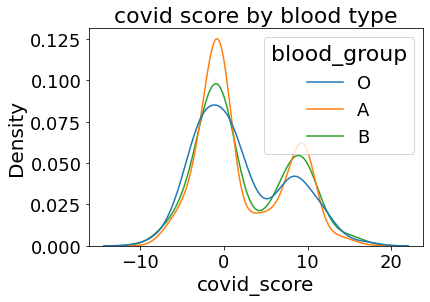

In [166]:
sns.kdeplot(data=blood_group_df_train, x='covid_score',
            hue='blood_group', common_norm=False)
plt.title('covid score by blood type')
plt.xlabel('covid_score')

Here we are splitting the train set into train and validation set

In [167]:
X_train, y_train = df_train[:1600].drop(['patient_id', 'covid_score', 'spread_score'], axis = 1).values, df_train[:1600]['covid_score'].values
X_val, y_val = df_train[1600:].drop(['patient_id', 'covid_score', 'spread_score'], axis = 1).values, df_train[1600:]['covid_score'].values


In [168]:
from sklearn.base import BaseEstimator, RegressorMixin


class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model
    """
    def __init__(self, lr: float = 1e-5):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, X, y):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """

        # TODO: complete the loss calculation
        loss = (1/len(y))*(np.linalg.norm(np.matmul(X,w) + np.ones_like(y)*b - y, ord=2))**2

        return loss

    @staticmethod
    def gradient(w, b: float, X, y):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # TODO: calculate the analytical gradient w.r.t w and b
        m = len(y)
        g_w = (2/m)*np.matmul(X.T,np.matmul(X,w) + np.ones_like(y)*b - y)
        g_b = (2/m)*np.matmul(np.ones_like(y).T,np.matmul(X,w) + np.ones_like(y)*b - y)

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                      X_val  =None, y_val = None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b, X, y))
            val_losses.append(self.loss(self.w, self.b, X_val, y_val))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # TODO: Compute the gradient for the current *batch*
            g_w, g_b = self.gradient(self.w, self.b, X,y)

            # Perform a gradient step
            # TODO: update the learned parameters correctly
            self.w -= self.lr*g_w
            self.b -= self.lr*g_b

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b,  X, y))
                val_losses.append(self.loss(self.w, self.b,  X_val, y_val))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """

        # TODO: Compute
        y_pred = np.matmul(X,self.w)+ self.b

        return y_pred

In [169]:
def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()

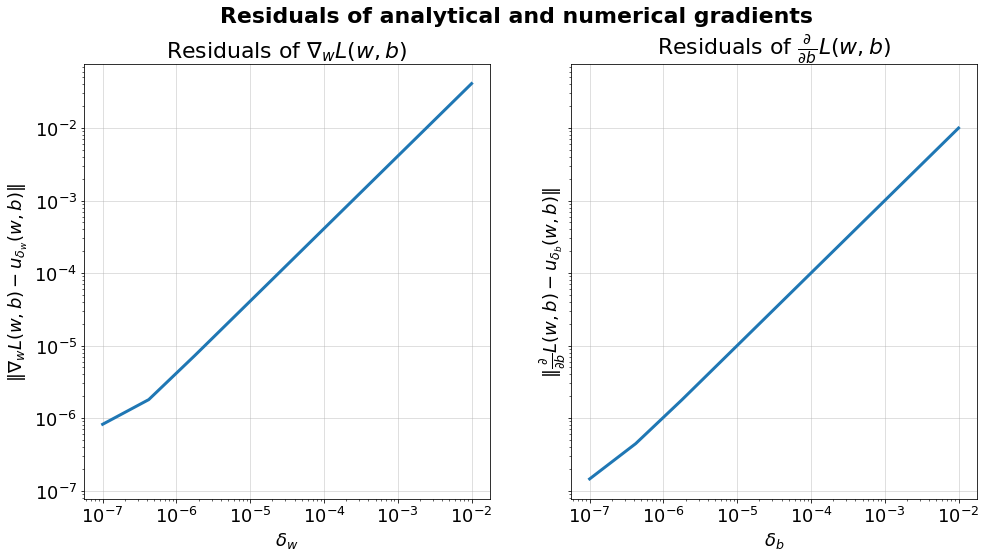

In [170]:

compare_gradients(X_train, y_train, deltas=np.logspace(-7, -2, 9))

In [171]:

def test_lr(X_train, y_train, X_val, y_val, title:str, max_iter = 1500):
    lr_list = np.logspace(-9, -1, 9)

    fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
    plt.suptitle(title, fontsize=32)
    plt.tight_layout()
    fig.subplots_adjust(hspace=0.5, top=0.9)

    axs = np.ravel(axs)
    for i, lr in enumerate(lr_list):
        cur_linear_reggressor = LinearRegressor(lr)
        train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
        print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

        iterations = np.arange(max_iter + 1)
        axs[i].semilogy(iterations, train_losses, label="Train")
        axs[i].semilogy(iterations, val_losses, label="Validation")
        axs[i].grid(alpha=0.5)
        axs[i].legend()
        axs[i].set_title('lr = '+str(lr))
        axs[i].set_xlabel('iteration')
        axs[i].set_ylabel('MSE')

lr size = 1e-09, Best train loss = 33.83634746892458, Best validation loss = 31.67774931280556
lr size = 1e-08, Best train loss = 33.83436890976549, Best validation loss = 31.676095988729703
lr size = 1e-07, Best train loss = 33.81459876302738, Best validation loss = 31.659576029530335
lr size = 1e-06, Best train loss = 33.61843138667798, Best validation loss = 31.495695239041904
lr size = 1e-05, Best train loss = 31.8003055125255, Best validation loss = 29.979905898926365
lr size = 0.0001, Best train loss = 21.758634845803808, Best validation loss = 21.61337035240683
lr size = 0.001, Best train loss = 5.41667158875513, Best validation loss = 5.773637553600942
lr size = 0.01, Best train loss = 3.4351260876264322, Best validation loss = 3.583017729290789
lr size = 0.1, Best train loss = 3.1277320186736235, Best validation loss = 3.332257095245655


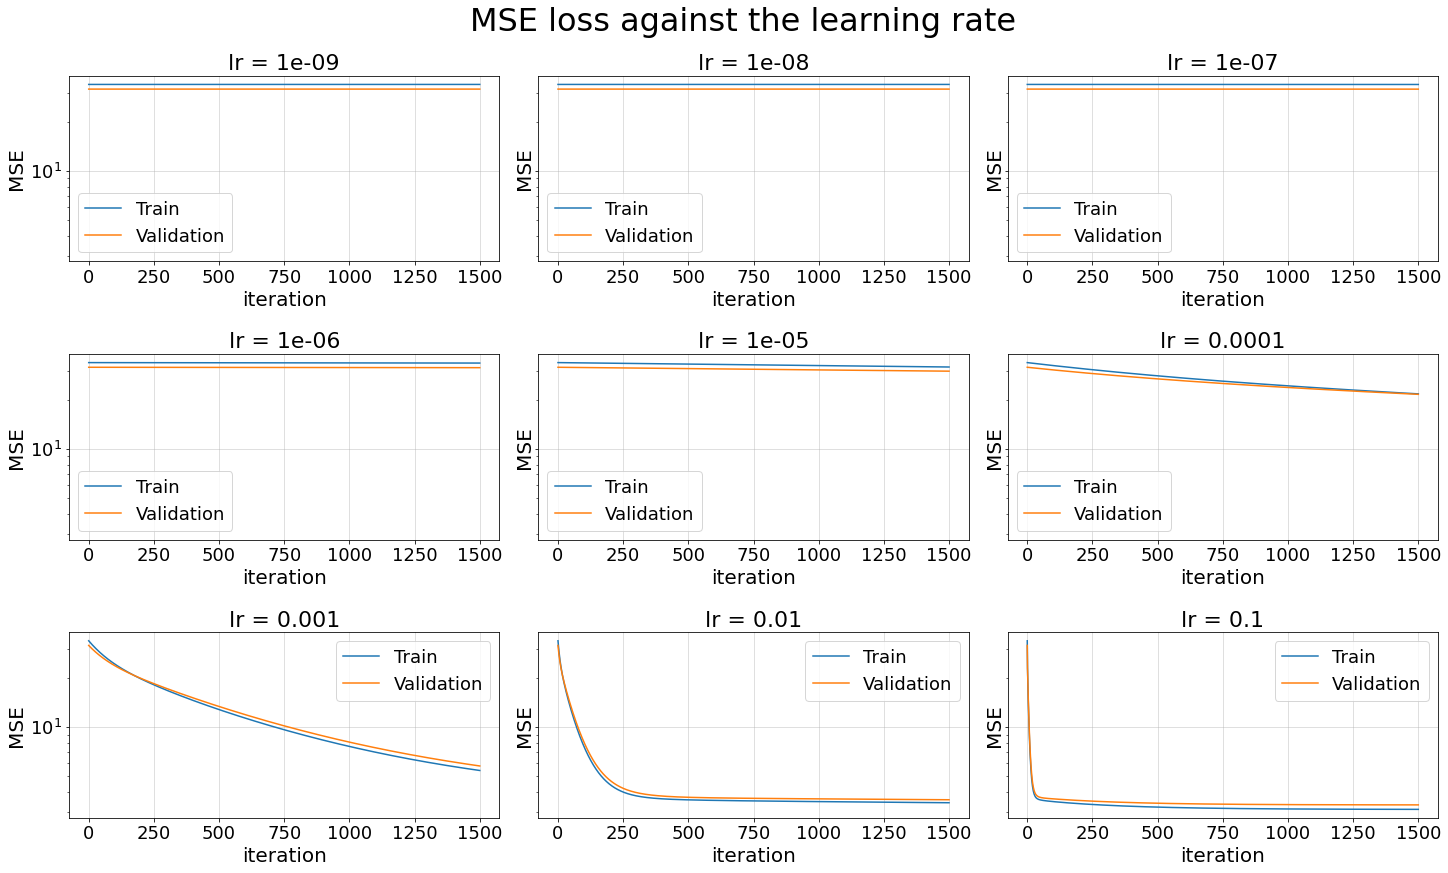

In [173]:
test_lr(X_train, y_train, X_val,y_val,'MSE loss against the learning rate')

In [251]:
def print_cv_result(cv_result):
    train_score = [round(a,2) for a in cv_result['train_score']]
    test_score = [round(a,2) for a in cv_result['test_score']]

    print(f'train scores = {train_score}\ntrain_mean = {round(np.mean(train_score), 2)}')
    print(f'test score = {test_score}\ntest mean = {round(np.mean(test_score), 2)}')


Creation of the dummy regressor.

In [252]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate

X_train, y_train = df_train.drop(['patient_id', 'covid_score', 'spread_score'], axis = 1).values, df_train['covid_score'].values

dummy = DummyRegressor(strategy='mean')
cv_result  = cross_validate(dummy, X_train,y_train,scoring='neg_mean_squared_error', cv= 5, return_train_score=True)

train_score = [round(a,2) for a in cv_result['train_score']]
test_score = [round(a,2) for a in cv_result['test_score']]

print_cv_result(cv_result)



train scores = [-28.77, -29.12, -29.1, -28.34, -28.95]
train_mean = -28.86
test score = [-29.23, -27.82, -27.92, -30.98, -28.53]
test mean = -28.9


17.736973859931155

In [235]:
dummy_to_save = DummyRegressor(strategy='mean')
dummy_to_save.fit(X_train, y_train)
dummy_train_mean = -28.86
dummy_test_mean = -28.9

for lr = 1e-06, train score: -33.267846001613606, test score = -33.269468775930264
for lr = 1e-05, train score: -32.094984683888846, test score = -32.1106085103303
for lr = 0.0001, train score: -24.373497840909362, test score = -24.485711559521498
for lr = 0.001, train score: -7.658834482661351, test score = -7.824765686932039
for lr = 0.01, train score: -3.4964999896345588, test score = -3.6014409431026335
for lr = 0.1, train score: -3.16056693005837, test score = -3.2773345649569974


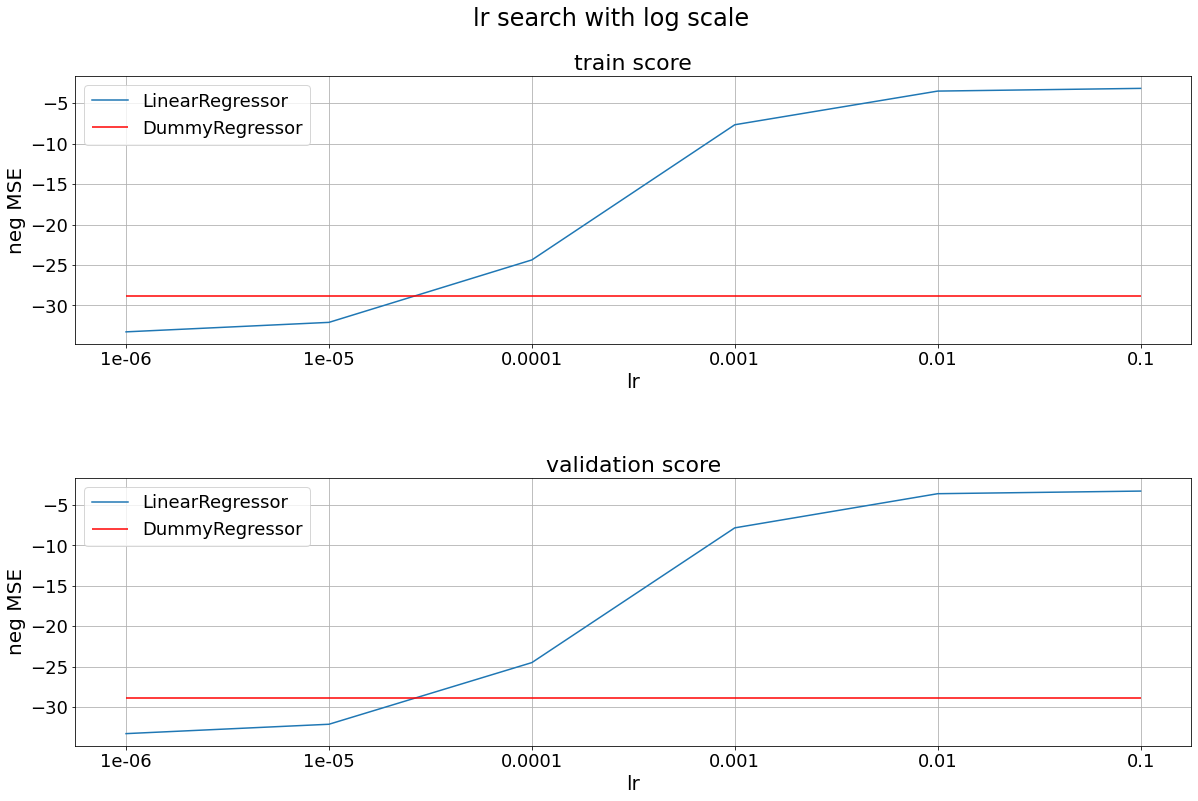

In [237]:
lr_list = np.logspace(-6,-1, 6)

fig, axs= plt.subplots(2,1, sharey=True, figsize=(20, 12))
fig.subplots_adjust(hspace=0.5, top=0.9)
fig.suptitle('lr search with log scale ')
train_score, test_score = [], []
for lr in lr_list:
    regressor = LinearRegressor(lr)
    cv_result = cross_validate(regressor,X_train, y_train,scoring='neg_mean_squared_error', cv= 5, return_train_score=True)
    train_score.append(np.mean(cv_result['train_score']))
    test_score.append(np.mean(cv_result['test_score']))

    print(f'for lr = {lr}, train score: {train_score[-1]}, test score = {test_score[-1]}')

axs[0].plot(train_score)
axs[0].set_title('train score')
axs[0].set_xlabel('lr')
axs[0].set_xticks(range(len(lr_list)),lr_list)
axs[0].set_ylabel('neg MSE')
axs[0].grid()
axs[0].hlines(dummy_train_mean, lr_list[0],len(lr_list)-1, colors='red')
axs[0].legend(['LinearRegressor', 'DummyRegressor'])
axs[1].plot(test_score)
axs[1].set_title('validation score')
axs[1].set_xlabel('lr')
axs[1].set_xticks(range(len(lr_list)),lr_list)
axs[1].set_ylabel('neg MSE')
axs[1].grid()
axs[1].hlines(dummy_test_mean, lr_list[0], len(lr_list)-1, colors='red')
axs[1].legend(['LinearRegressor', 'DummyRegressor'])
plt.show()


Creation of the linear regressor.


for lr = 0.1, train score: -3.161, test score = -3.277
for lr = 0.119, train score: -3.150, test score = -3.267
for lr = 0.138, train score: -3.145, test score = -3.261
for lr = 0.157, train score: -3.141, test score = -3.258
for lr = 0.176, train score: -3.139, test score = -3.256
for lr = 0.194, train score: -3.138, test score = -3.255
for lr = 0.213, train score: -3.138, test score = -3.254
for lr = 0.232, train score: -3.137, test score = -3.254
for lr = 0.251, train score: -3.137, test score = -3.253
for lr = 0.27, train score: -3.137, test score = -3.253


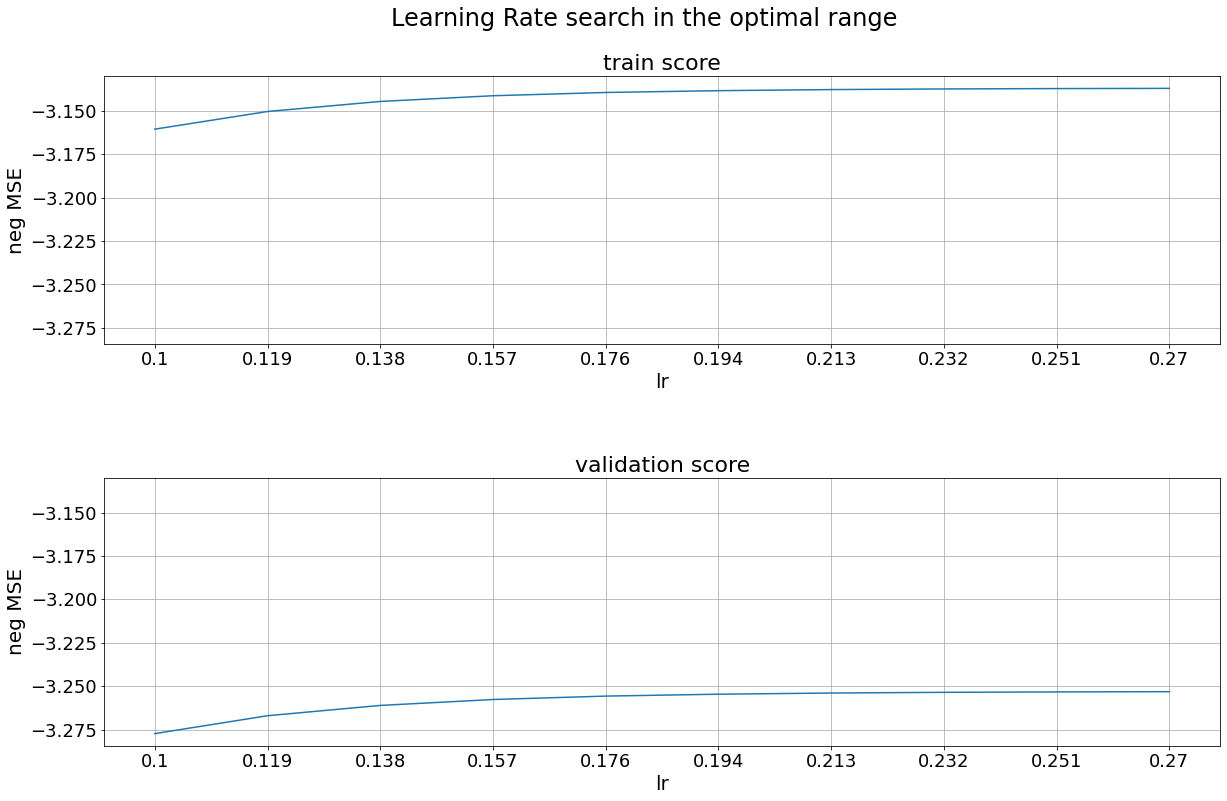

In [246]:

#lr_list = np.logspace(-6,-1, 6)
lr_list = [round(a,3) for a in np.linspace(0.1, 0.27, 10)]
fig, axs= plt.subplots(2,1, sharey=True, figsize=(20, 12))
fig.subplots_adjust(hspace=0.5, top=0.9)
fig.suptitle('Learning Rate search in the optimal range')
train_score, test_score = [], []
for lr in lr_list:
    regressor = LinearRegressor(lr)
    cv_result = cross_validate(regressor,X_train, y_train,scoring='neg_mean_squared_error', cv= 5, return_train_score=True)
    train_score.append(np.mean(cv_result['train_score']))
    test_score.append(np.mean(cv_result['test_score']))

    print(f'for lr = {lr}, train score: {train_score[-1]: .3f}, test score = {test_score[-1]: .3f}')

axs[0].plot(train_score)
axs[0].set_title('train score')
axs[0].set_xlabel('lr')
axs[0].set_xticks(range(len(lr_list)),lr_list)
axs[0].set_ylabel('neg MSE')
axs[0].grid()

axs[1].plot(test_score)
axs[1].set_title('validation score')
axs[1].set_xlabel('lr')
axs[1].set_xticks(range(len(lr_list)),lr_list)
axs[1].set_ylabel('neg MSE')
axs[1].grid()

plt.show()



In [253]:
best_linear_regressor = LinearRegressor(0.27)
cv_res = cross_validate(best_linear_regressor,X_train, y_train,scoring='neg_mean_squared_error', cv=5, return_train_score=True)
print_cv_result(cv_res)


train scores = [-3.06, -3.1, -3.1, -3.3, -3.12]
train_mean = -3.14
test score = [-3.58, -3.37, -3.41, -2.58, -3.33]
test mean = -3.25


In [254]:
linear_to_save = LinearRegressor(0.27)
linear_to_save.fit(X_train, y_train)

LinearRegressor(lr=0.27)